In [64]:
import numpy as np
import librosa
import os
from os import walk
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import datetime 
import pandas as pd

In [65]:
import librosa
import numpy as np

def get_chroma_vector(wav_file_path, target_duration=3):
    y, sr = librosa.load(wav_file_path, sr=None)
    current_duration = librosa.get_duration(y=y, sr=sr)
    
    # Calculez le facteur d'étirement ou de compression nécessaire
    time_stretch_factor = current_duration / target_duration
    
    # Étirez ou compressez le signal audio pour atteindre la durée cible
    y_stretched = librosa.effects.time_stretch(y,rate=time_stretch_factor)
    
    # Calculez le chromagramme à partir du signal modifié
    chroma = np.array(librosa.feature.chroma_stft(y=y_stretched, sr=sr))

    df_chroma = pd.DataFrame(chroma)
    moyenne_par_colonne = df_chroma.mean()

    # Sélectionnez les colonnes dont la moyenne est inférieure ou égale à 0.6
    colonnes_a_conserver = moyenne_par_colonne[moyenne_par_colonne <= 0.65].index

    # Créez un nouveau DataFrame en ne conservant que les colonnes sélectionnées
    df_filtered = df_chroma[colonnes_a_conserver]
    new_chroma = df_filtered.to_numpy()
    return new_chroma


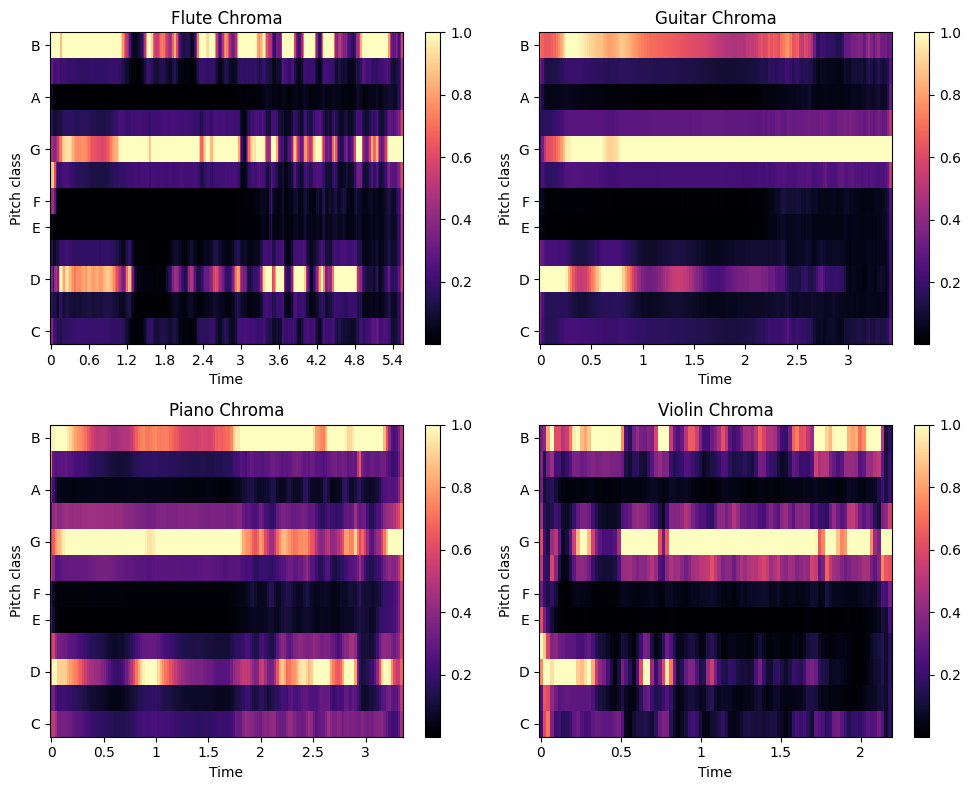

In [66]:
import matplotlib.pyplot as plt

# Obtenez les 4 chromagrammes (remplacez ces lignes par les données réelles que vous avez)
chroma1 = get_chroma_vector('Chords_generation/chords_wav/F_Gmaj.wav')
chroma2 = get_chroma_vector('Chords_generation/chords_wav/G_Gmaj.wav')
chroma3 = get_chroma_vector('Chords_generation/chords_wav/P_Gmaj.wav')
chroma4 = get_chroma_vector('Chords_generation/chords_wav/V_Gmaj.wav')

# Créez une figure avec une grille de 2x2 sous-plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Affichez chaque chromagramme dans un sous-plot
img1 = librosa.display.specshow(chroma1, y_axis='chroma', x_axis='time', ax=axes[0, 0])
axes[0, 0].set_title('Flute Chroma')

img2 = librosa.display.specshow(chroma2, y_axis='chroma', x_axis='time', ax=axes[0, 1])
axes[0, 1].set_title('Guitar Chroma')

img3 = librosa.display.specshow(chroma3, y_axis='chroma', x_axis='time', ax=axes[1, 0])
axes[1, 0].set_title('Piano Chroma')

img4 = librosa.display.specshow(chroma4, y_axis='chroma', x_axis='time', ax=axes[1, 1])
axes[1, 1].set_title('Violin Chroma')

# Ajoutez une barre de couleur pour chaque sous-plot
fig.colorbar(img1, ax=axes[0, 0])
fig.colorbar(img2, ax=axes[0, 1])
fig.colorbar(img3, ax=axes[1, 0])
fig.colorbar(img4, ax=axes[1, 1])

# Ajustez l'espacement entre les sous-plots
plt.tight_layout()

# Affichez la figure
plt.show()


In [67]:
def get_feature(file_path):
 # Extracting chroma vector feature
  chroma = get_chroma_vector(file_path)
  chroma_mean = chroma.mean(axis=1)

  feature = chroma_mean
  return feature

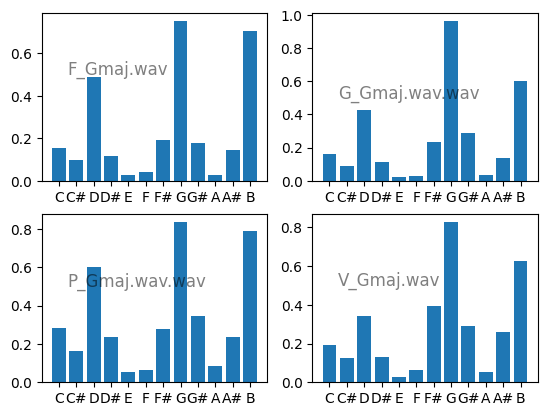

In [68]:
names = ['C', 'C#', 'D','D#','E','F','F#','G','G#','A','A#','B'] # nom des barres

values_f = get_feature('Chords_generation/chords_wav/F_Gmaj.wav').tolist()
values_g = get_feature('Chords_generation/chords_wav/G_Gmaj.wav').tolist()
values_p = get_feature('Chords_generation/chords_wav/P_Gmaj.wav').tolist()
values_v = get_feature('Chords_generation/chords_wav/V_Gmaj.wav').tolist()

plt.subplot(221)
plt.bar(names, values_f)
plt.text(0.5, 0.5, "F_Gmaj.wav", size=12, alpha=.5)

plt.subplot(222)
plt.bar(names, values_g)
plt.text(0.5,0.5, "G_Gmaj.wav.wav", size=12, alpha=.5)

plt.subplot(223)
plt.bar(names, values_p)
plt.text(0.5,0.5, "P_Gmaj.wav.wav", size=12, alpha=.5)

plt.subplot(224)
plt.bar(names, values_v)
plt.text(0.5,0.5, "V_Gmaj.wav", size=12, alpha=.5)

plt.show()


In [69]:
def extract_features(directory):
    features = []
    labels = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            feature = get_feature(file_path)
            label = file.split('_')[1].split('.')[0]
            features.append(feature)
            labels.append(label)

    return features, labels

In [70]:
dir = 'Chords_generation\chords_wav'
features, labels = extract_features(dir)

In [71]:
permutations = np.random.permutation(408)

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

features = np.array(features)[permutations]
labels_encoded = np.array(labels_encoded)[permutations]

In [72]:
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [77]:
model = keras.Sequential()
model.add(keras.layers.Input(shape=(12,)))
model.add(keras.layers.Dense(35, activation='relu'))
model.add(keras.layers.Dense(103, activation='softmax'))
model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [78]:
history =model.fit(X_train,y_train,epochs=50,validation_data=(X_val, y_val))


Epoch 1/64
11/11 [==============================] - 0s 2ms/step - loss: 4.6275 - accuracy: 0.0184
Epoch 2/64
11/11 [==============================] - 0s 2ms/step - loss: 4.5396 - accuracy: 0.1043
Epoch 3/64
11/11 [==============================] - 0s 2ms/step - loss: 4.4464 - accuracy: 0.1442
Epoch 4/64
11/11 [==============================] - 0s 2ms/step - loss: 4.3217 - accuracy: 0.1380
Epoch 5/64
11/11 [==============================] - 0s 2ms/step - loss: 4.1601 - accuracy: 0.1840
Epoch 6/64
11/11 [==============================] - 0s 2ms/step - loss: 3.9651 - accuracy: 0.2086
Epoch 7/64
11/11 [==============================] - 0s 2ms/step - loss: 3.7528 - accuracy: 0.2209
Epoch 8/64
11/11 [==============================] - 0s 2ms/step - loss: 3.5183 - accuracy: 0.2393
Epoch 9/64
11/11 [==============================] - 0s 2ms/step - loss: 3.2910 - accuracy: 0.3006
Epoch 10/64
11/11 [==============================] - 0s 2ms/step - loss: 3.0665 - accuracy: 0.3006
Epoch 11/64
11/11 [

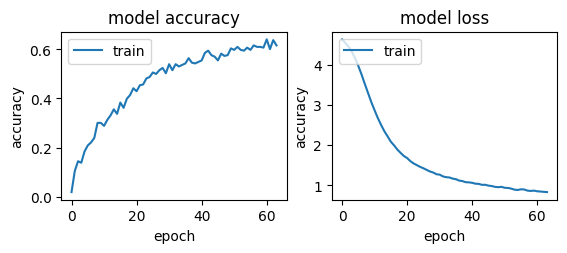

In [79]:
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(222)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [80]:
score = model.evaluate(x=X_test.tolist(),y=y_test.tolist(), verbose=0)
print('Accuracy : ' + str(score[1]*100) + '%')

Accuracy : 25.609755516052246%
